One-sample t: TtestResult(statistic=np.float64(-7.404526160660084), pvalue=np.float64(1.540708297596087e-13), df=np.int64(4908))
Two-sample t (BMI): TtestResult(statistic=np.float64(1.7716439352358526), pvalue=np.float64(0.07667122980547719), df=np.float64(1399.6465609322831))
ANOVA:
                     sum_sq      df           F        PR(>F)
C(work_type)  1.344152e+05     2.0  214.706056  1.608141e-89
Residual      1.318759e+06  4213.0         NaN           NaN
Tukey:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
 group1      group2    meandiff p-adj  lower   upper  reject
------------------------------------------------------------
Govt_job       Private  -5.5136   0.0 -7.3421 -3.6852   True
Govt_job Self-employed   9.1987   0.0  6.9735 11.4238   True
 Private Self-employed  14.7123   0.0 13.0294 16.3952   True
------------------------------------------------------------


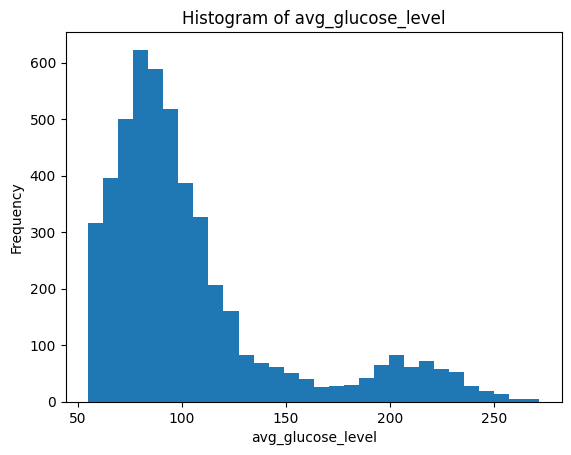

/tmp/ipython-input-3936243398.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([smokers.dropna(), nonsmokers.dropna()], labels=['smokes','never smoked'], showmeans=True)


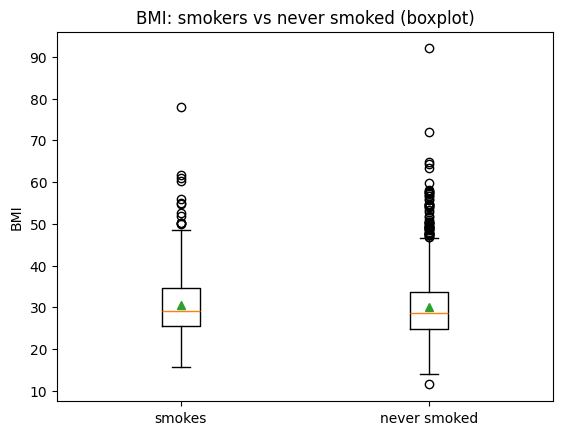

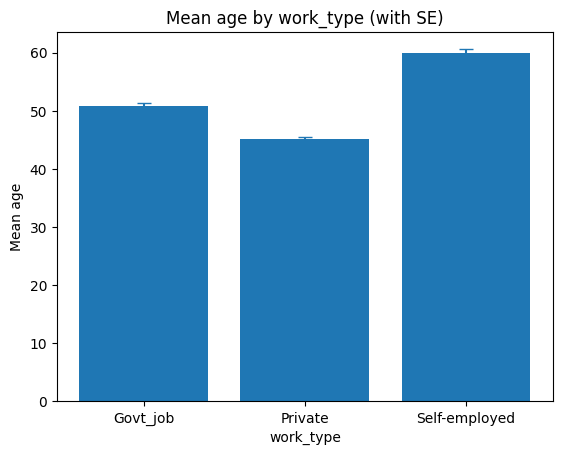

Saved: /content/YourName_CaseStudy.xlsx


In [9]:
import zipfile, os
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# (If zipped) extract the zip to /mnt/data/stroke_dataset — skip if csv already available
# zip_path = "/mnt/data/archive (2).zip"
# extract_path = "/mnt/data/stroke_dataset"
# if not os.path.exists(extract_path):
#     with zipfile.ZipFile(zip_path, 'r') as z: z.extractall(extract_path)

# file_path = os.path.join(extract_path, "healthcare-dataset-stroke-data.csv")
file_path = "/content/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(file_path)

# Clean: drop rows with missing BMI
df_clean = df.dropna(subset=["bmi"]).copy()

# One-sample t-test: avg_glucose_level vs 110
one_sample_res = stats.ttest_1samp(df_clean["avg_glucose_level"], 110, nan_policy='omit')

# Two-sample t-test: BMI for smokers vs never smoked
smokers = df_clean[df_clean["smoking_status"]=="smokes"]["bmi"]
nonsmokers = df_clean[df_clean["smoking_status"]=="never smoked"]["bmi"]
two_sample_res = stats.ttest_ind(smokers, nonsmokers, equal_var=False, nan_policy='omit')

# ANOVA (age ~ work_type) and Tukey
df_anova = df_clean[df_clean["work_type"].isin(["Private","Govt_job","Self-employed"])].copy()
anova_model = sm.OLS.from_formula("age ~ C(work_type)", data=df_anova).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)
tukey = pairwise_tukeyhsd(df_anova['age'], df_anova['work_type'])

print("One-sample t:", one_sample_res)
print("Two-sample t (BMI):", two_sample_res)
print("ANOVA:\n", anova_table)
print("Tukey:\n", tukey.summary())

# PLOTS (matplotlib only)
plt.hist(df_clean["avg_glucose_level"].dropna(), bins=30)
plt.title("Histogram of avg_glucose_level"); plt.xlabel("avg_glucose_level"); plt.ylabel("Frequency")
plt.show()

plt.boxplot([smokers.dropna(), nonsmokers.dropna()], labels=['smokes','never smoked'], showmeans=True)
plt.title("BMI: smokers vs never smoked (boxplot)"); plt.ylabel("BMI"); plt.show()

grouped = df_anova.groupby('work_type')['age'].agg(['mean','count','std']).reset_index()
grouped['se'] = grouped['std'] / grouped['count']**0.5
plt.bar(grouped['work_type'], grouped['mean'])
plt.errorbar(grouped['work_type'], grouped['mean'], yerr=grouped['se'], fmt='none', capsize=5)
plt.title("Mean age by work_type (with SE)"); plt.xlabel("work_type"); plt.ylabel("Mean age")
plt.show()

# Save cleaned excel (README + Cleaned_Data)
out_excel = "/content/YourName_CaseStudy.xlsx"
with pd.ExcelWriter(out_excel, engine='openpyxl') as writer:
    readme = pd.DataFrame({"Dataset Source":["Kaggle - Stroke Prediction Dataset"],
                           "Link":["https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset"],
                           "Notes":["Dropped rows with missing BMI for analyses."]})
    readme.to_excel(writer, sheet_name="README", index=False)
    df_clean.to_excel(writer, sheet_name="Cleaned_Data", index=False)
print("Saved:", out_excel)